# Today you are a MLE@Samsung Research and your goal is to perform segmentation of cystic regions from OCT images.
## This work is based on the recent publication https://arxiv.org/abs/2008.02952
## This model is adapted from the original codebase in https://github.com/sohiniroych/U-net_using_TF2

# Optical Coherence Tomography (OCT) images represent grayscale images representing the depth of retina. Cystic regions are gaps in the retina as shown below
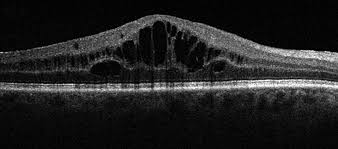

## Yor goal is to segment the cysts (dark gaps) in the images using the U-net model.

# Your Deliverables are as follows:
### 1. Train a u-net model from scratch and test performance on test images for 2 OCT repos.
### 2. Vary the loss function, kernel dialation, depthwise separable kernels and report results.
### 3. Report observations with and without Batch normalization and Dropout at test time.
### 4. If you use Dropout at test time and generate 2-3 test predictions, what do you observe from these predictions? 

# Task 1: Implement U-net model from scratch for the 'cirrus_3' data set. Report performance on test set and save the model as 'unet_cirrus.hdf5'
## [Instructor Led]

In [1]:
#This code snippet helps if your computer has RTX 2070 GPU. If not then comment this cell.
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Lets start by stepwise defining all libraries and functions needed to generate the model and pre-process the data

In [2]:
#Step 1: Load libraries for the U-net Model
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
#from tensorflow import keras
import tensorflow as tf

ModuleNotFoundError: No module named 'skimage'

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
import scipy.misc as sc

In [ ]:
#Define Additional loss functions for Task 2
def dice_coef(y_true, y_pred, smooth=1):
    intersection = keras.sum(y_true * y_pred, axis=[1,2,3])
    union = keras.sum(y_true, axis=[1,2,3]) + keras.sum(y_pred, axis=[1,2,3])
    return keras.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [4]:
#Step 2: Define the U-net model
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(inputs) #dialation_rate=2 etc.
    #[Try DepthwiseConv2D instead of Conv2D for depthwise separable filters]
    conv1 = BatchNormalization()(conv1)
    #[Try removing BatchNormalization and see performance]
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)#training=True will enable dropout for test data
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = 'accuracy')
    # Modify loss function above to dice_coef_loss defined above, and metrics to dice_coef
    

    if(pretrained_weights):
    	model=keras.models.load_model(pretrained_weights)

    return model

In [1]:
#All additional functions for data prep and evaluation are housed in unet_helper_finctions.py
from unet_helper_functions import *

## All definitions are now done! Lets start using the functions now...
## B. Call to image data generator, model initialization, followed by model fitting.

In [6]:
#Step 1: Call to image data generator in keras
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=[0.7,1],
                    horizontal_flip=True,
                    fill_mode='nearest')
PATH='./Data/cirrus_3/train/'

In [7]:
if not os.path.exists(PATH+'aug'):
    os.makedirs(PATH+'aug')
    
if not os.path.exists('./Data/cirrus_3/test/'+'pred'):
    os.makedirs('./Data/cirrus_3/test/'+'pred')    
data_gen = trainGenerator(10,PATH,'Image','GT',data_gen_args, save_to_dir = PATH+'aug')

In [8]:
#Step 2: Initialize the model. Train from scratch!
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
#Step 3: Initialize Tensorboard to monitor changes in Model Loss 
import datetime
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [10]:
#Step 4: Fit the u-net model
#model_checkpoint = tf.keras.callbacks.ModelCheckpoint('unet_cirrus.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit(data_gen,steps_per_epoch=15,epochs=50,verbose=1)#callbacks=[tensorboard_callback])

Found 91 images belonging to 1 classes.
Found 91 images belonging to 1 classes.
Epoch 1/50
15/15 [==============================] - 11s 705ms/step - loss: 0.4569 - accuracy: 0.9185
Epoch 2/50
15/15 [==============================] - 7s 498ms/step - loss: 0.1018 - accuracy: 0.9489
Epoch 3/50
15/15 [==============================] - 8s 535ms/step - loss: 0.0759 - accuracy: 0.9498
Epoch 4/50
15/15 [==============================] - 8s 503ms/step - loss: 0.0700 - accuracy: 0.9502
Epoch 5/50
15/15 [==============================] - 8s 537ms/step - loss: 0.0679 - accuracy: 0.9498
Epoch 6/50
15/15 [==============================] - 8s 504ms/step - loss: 0.0684 - accuracy: 0.9484
Epoch 7/50
15/15 [==============================] - 8s 540ms/step - loss: 0.0658 - accuracy: 0.9489
Epoch 8/50
15/15 [==============================] - 8s 506ms/step - loss: 0.0633 - accuracy: 0.9507
Epoch 9/50
15/15 [==============================] - 9s 569ms/step - loss: 0.0632 - accuracy: 0.9496
Epoch 10/50
15/15 [

In [11]:
%tensorboard --logdir logs/fit

## C. Run the trained model on test images and save the outputs, and evaluate pixel-level segmentation performance 

In [12]:
#Step 1: Run model on test images and save the images
#number of test images
n_i=len(os.listdir('./Data/cirrus_3/test/Image/'))
#Call test generator
test_gen = testGenerator('./Data/cirrus_3/test/Image/')
#Return model outcome for each test image
results = model.predict_generator(test_gen,n_i,verbose=1)
#If dropout is activated for test data, then calling this function multiple times will generate difefrent outputs!
saveResult('./Data/cirrus_3/test/Image/','./Data/cirrus_3/test/pred/',results)

Instructions for updating:
Please use Model.predict, which supports generators.
48/48 [==============================] - 1s 27ms/step


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

In [13]:
#Step 2: Evaluate the predicted outcome
gt_path='./Data/cirrus_3/test/GT/'
evalResult(gt_path,results)

Precision= 0.20281269023702472 Recall= 0.7904092937132816 IoU= 0.19264802328255246 acc= 0.9791825612386068 F1= 0.2982734908172013


# Task 2: Vary kernels (dialated kernels), separable filters, loss function and rerun whole process. Does it improve test performance?
### Enter your results in the table below

```
U-net Parameters  (cirrus_3)          | Precision|Recall|IoU   |acc   |F1    |
-------------------------------------------------------------------------------
3x3 kernels, binary cross entropy     |           |     |      |      |      |
------------------------------------------------------------------------------
5x5 kernels, dilated kernels,dice_coef|           |     |      |      |      |
------------------------------------------------------------------------------
5x5 kernels, dilated, depthwise       |           |     |      |      |      |
separable kernels,dice_coef           |           |     |      |      |      |
------------------------------------------------------------------------------
````

## Select the best network parameters for semantic segmentation here and save the best unet_cirrus3.hdf5 model!

# Task 3: Perform transfer learning with 'unet_cirrus3.hdf5' as base weights and retrain on the 'nidek1' data set (lesser epochs). Report the same table as above for the 'nidek1' test data.

# Task 4: Report test data performance on Cirrus3 and Nidek1 for the following:
## A. Remove the BatchNormalization commands and add more batch normalizations after each conv2D layer for decoder networks.
## B. Activate dropout to test data (enable training=True) and create 2 cyst masks for each test image. Comment on the overlap between the cyst masks per image. What do you learn here?